<a href="https://colab.research.google.com/github/CalculatedContent/ww-phys_theory/blob/master/Full_Test_Jacobians_Resnets_SVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook for generating Full Jacobian SVD over the test data for ResNet data


June 5 2020

```
resnet20_cifar10
resnet56_cifar10
resnet110_cifar10
resnet164bn_cifar10
resnet272bn_cifar10
resnet542bn_cifar10
resnet1001_cifar10
resnet1202_cifar10
```




In [0]:
Jdir =  '/content/drive/My Drive/J_resnets_fullsvd'

thismodel = 'resnet542bn_cifar10'
start_batch = 2

batch_size = 100

num_classes= 10
device = 'cuda:0'
num_data = 10000


In [2]:
!pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [3]:
!pip install ipython-autotime
%load_ext autotime

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=4fa368672c9c3e3db81e253bcd7f71707baec9cd4ed80332543932967be2436b
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
time: 23.1 s


In [5]:
!mkdir "$Jdir"
!ls "$Jdir"

mkdir: cannot create directory ‘/content/drive/My Drive/J_resnets_fullsvd’: File exists
data				 Jfull_resnet542bn_cifar10__0.csv
Jfull_resnet1001_cifar10__0.csv  Jfull_resnet542bn_cifar10__1.csv
time: 2.01 s


In [6]:
!pip install pytorchcv
!pip install powerlaw
!pip install GPUtil
import GPUtil

     |████████████████████████████████| 440kB 2.8MB/s 
  Created wheel for powerlaw: filename=powerlaw-1.4.6-cp36-none-any.whl size=24787 sha256=06794359e511645b79727027d48f496d9b58cbec85e715caa7353caa349603df
  Stored in directory: /root/.cache/pip/wheels/e0/27/02/08d0e2865072bfd8d7c655e290521e3feca3fc22f1ac460601
Successfully built powerlaw
  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=1d018b9ace79c456fc183fd5cbda83b9ff7c322060184ba6a2b91889fca38f86
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil
time: 11.9 s


In [7]:
!import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

import math
import copy

import gc


/bin/bash: import: command not found
time: 4.36 s


### Run InstallPhysTheory notebook 

In [8]:
import sys
sys.path.append("/content/drive/My Drive/Jacobian")
import jacobian as jac
import utils

time: 498 ms


In [9]:
def jacobian_batched_full(modelname, model, data_loader, batch_size, start_batch = 0, num_classes=10, device='cuda:0', data_dim=3*32*32, formJJ=False, save=True): 
  '''Compute a full of J^{T}J Jacobian in batch mode.  '''

  model.eval() 
  model = model.to(device)

  left_data_loader = data_loader 
  right_data_loader = copy.deepcopy(data_loader)

  JJMat = None 
  for left_batch, data in enumerate(left_data_loader): 
    if left_batch < start_batch:
      continue
    print(left_batch) 

    inputs, _ = data 
    inputs = inputs.to(device)
    inputs.requires_grad=True
    outputs = model(inputs)
    J = jac.batch_diagJ(inputs, outputs)
    J = J.reshape(batch_size,num_classes*data_dim)

    X = J.detach().cpu().numpy()

    del data, inputs, outputs, J
    gc.collect()
    torch.cuda.empty_cache()
    GPUtil.showUtilization()

    JJBlock = None
    for right_batch, data in enumerate(right_data_loader):
      print(left_batch, right_batch)
      inputs, _ = data 
      inputs = inputs.to(device)
      inputs.requires_grad=True
      outputs = model(inputs)
    
      Jt = jac.batch_diagJ(inputs, outputs)
      Jt = Jt.reshape(batch_size,num_classes*data_dim)

      Xt = Jt.detach().cpu().numpy().transpose()

      del data, inputs, outputs, Jt
      gc.collect()
      torch.cuda.empty_cache()

      block = np.dot(X,Xt)
      JJBlock = np.hstack([JJBlock, block]) if JJBlock is not None else block

    # end of right_batch loop
    
    if save:
      filename = "{}/Jfull_{}__{}.csv".format(Jdir, modelname, left_batch)
      np.savetxt(filename, JJBlock, delimiter='\t')
      print("Saved file ",filename)

    if formJJ:
      JJMat = np.vstack([JJMat, JJBlock]) if JJMat is not None else JJBlock

      print("JJMat shape ", left_batch, JJMat.shape, filename) 

  # end of left_batch loop

  return JJMat


time: 58 ms


In [10]:
def jacobian_full(model, data_loader, batch_size, num_classes=10, device='cuda:0', data_dim=3*32*32): 
  '''compute a full of J^{T}J Jacobian, as a torch tensor'''

  model.eval()
  model = model.to(device)

  J_right = jac.construct_diagJ(model, test_loader, batch_size=batch_size, device=device) 
  J_left = J_right.transpose(1,0)
  JJ = torch.mm(J_right, J_left)

  del J_right, J_left
  gc.collect()
  torch.cuda.empty_cache()

  return JJ

time: 7.25 ms


### ResNet 

In [11]:
import pytorchcv
from pytorchcv.model_provider import get_model as ptcv_get_model

time: 105 ms


### Compute JJ, in batches or all at once


In [12]:
print(thismodel)
train_dataset, test_dataset, train_loader, test_loader = utils.get_data(batch_size=batch_size)

model = ptcv_get_model(thismodel, pretrained=True)  
jacobian_batched_full(thismodel, model, test_loader, batch_size=batch_size, start_batch=2)


resnet542bn_cifar10


Streaming output truncated to the last 5000 lines.
52 38
52 39
52 40
52 41
52 42
52 43
52 44
52 45
52 46
52 47
52 48
52 49
52 50
52 51
52 52
52 53
52 54
52 55
52 56
52 57
52 58
52 59
52 60
52 61
52 62
52 63
52 64
52 65
52 66
52 67
52 68
52 69
52 70
52 71
52 72
52 73
52 74
52 75
52 76
52 77
52 78
52 79
52 80
52 81
52 82
52 83
52 84
52 85
52 86
52 87
52 88
52 89
52 90
52 91
52 92
52 93
52 94
52 95
52 96
52 97
52 98
52 99
Saved file  /content/drive/My Drive/J_resnets_fullsvd/Jfull_resnet542bn_cifar10__52.csv
53
| ID | GPU | MEM |
------------------
|  0 | 84% |  5% |
53 0
53 1
53 2
53 3
53 4
53 5
53 6
53 7
53 8
53 9
53 10
53 11
53 12
53 13
53 14
53 15
53 16
53 17
53 18
53 19
53 20
53 21
53 22
53 23
53 24
53 25
53 26
53 27
53 28
53 29
53 30
53 31
53 32
53 33
53 34
53 35
53 36
53 37
53 38
53 39
53 40
53 41
53 42
53 43
53 44
53 45
53 46
53 47
53 48
53 49
53 50
53 51
53 52
53 53
53 54
53 55
53 56
53 57
53 58
53 59
53 60
53 61
53 62
53 63
53 64
53 65
53 66
53 67
53 68
53 69
53 70
53 71
53 72
5

In [40]:
JJMat = None
import os, glob
os.chdir(Jdir)
for filename in glob.glob("Jfull_resnet542bn_cifar10*"):
  print(filename)
  JJBlock = np.loadtxt(filename)
  JJMat = np.vstack([JJMat, JJBlock]) if JJMat is not None else JJBlock


Jfull_resnet542bn_cifar10__0.csv
Jfull_resnet542bn_cifar10__1.csv
Jfull_resnet542bn_cifar10__2.csv
Jfull_resnet542bn_cifar10__3.csv
Jfull_resnet542bn_cifar10__4.csv
Jfull_resnet542bn_cifar10__5.csv
Jfull_resnet542bn_cifar10__6.csv
Jfull_resnet542bn_cifar10__7.csv
Jfull_resnet542bn_cifar10__8.csv
Jfull_resnet542bn_cifar10__9.csv
Jfull_resnet542bn_cifar10__10.csv
Jfull_resnet542bn_cifar10__11.csv
Jfull_resnet542bn_cifar10__12.csv
Jfull_resnet542bn_cifar10__13.csv
Jfull_resnet542bn_cifar10__14.csv
Jfull_resnet542bn_cifar10__15.csv
Jfull_resnet542bn_cifar10__16.csv
Jfull_resnet542bn_cifar10__17.csv
Jfull_resnet542bn_cifar10__18.csv
Jfull_resnet542bn_cifar10__19.csv
Jfull_resnet542bn_cifar10__20.csv
Jfull_resnet542bn_cifar10__21.csv
Jfull_resnet542bn_cifar10__22.csv
Jfull_resnet542bn_cifar10__23.csv
Jfull_resnet542bn_cifar10__24.csv
Jfull_resnet542bn_cifar10__25.csv
Jfull_resnet542bn_cifar10__26.csv
Jfull_resnet542bn_cifar10__27.csv
Jfull_resnet542bn_cifar10__28.csv
Jfull_resnet542bn_cifar1

Calculating best minimal value for power law fit
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


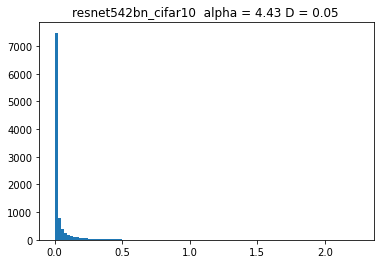

time: 6min 27s


In [52]:
import powerlaw
norm = 10*3*32*32
#JJMAt assumed to be normalized already
evals = np.linalg.eigvals(JJMat)
evals  = (1.0/ norm)*evals

fit = powerlaw.Fit(evals)
alpha = fit.alpha
D = fit.D

plt.hist(evals, bins=100)
plt.title("{}  alpha = {:0.2f} D = {:0.2f} ".format(thismodel, alpha, D))
plt.show()
